## Long Short-Term Memory (LSTMs)

In [13]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
# Import feature and target columns
df = pickle.load(open("../../common/pima.p", "rb"))

### Perform Cross Validation

### Train the model

In [15]:
# Create function to prepare data sequences
def create_sequences(input_data, n_past, n_future, target_column_index):
    X, y = [], []
    for window_start in range(len(input_data) - n_past - n_future + 1):
        past_end = window_start + n_past
        future_end = past_end + n_future
        X.append(input_data[window_start:past_end, :])
        y.append(input_data[past_end:future_end, target_column_index])
    return np.array(X), np.array(y)

In [16]:
# Specify the columns to predict
target_columns = ["cpu_usage","memory_usage","bandwidth_inbound","bandwidth_outbound","tps","tps_error","response_time"]

# Initialize a dictionary to store the scalers
scalers = {}

# Scale each target column individually and store the scaler
scaled_df = df[target_columns].copy()
for i, target_col in enumerate(target_columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df[target_col] = scaler.fit_transform(df[[target_col]].values)
    scalers[target_col] = scaler

# Convert the DataFrame back to a numpy array
scaled_df = scaled_df.values

# Prepare the training and test sets
train_size = int(len(scaled_df) * 0.8)
test_size = len(scaled_df) - train_size
train, test = scaled_df[:train_size, :], scaled_df[train_size:, :]

n_past = 2  # number of past time steps to use as inputs
n_future = 1  # number of time steps to predict into the future

# Get test statuses data
statuses_df = df[["status"]].copy().values
status_size = train_size + n_past
status_test = statuses_df[status_size:, :].copy()
statuses = status_test[:, -1]

In [18]:
# Train models and make initial predictions
models = {}
initial_predictions = {}
for i, target_col in enumerate(target_columns):
    # Prepare sequences
    X_train, y_train = create_sequences(train, n_past, n_future, i)
    X_test, y_test = create_sequences(test, n_past, n_future, i)

    # Design LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_past, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(n_future))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    models[target_col] = model

    # Initial prediction
    initial_predictions[target_col] = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


### Predict the value

In [19]:
# Recursive multi-step forecast
n_steps = len(test) - n_past
predictions = {col: [] for col in target_columns}
for step in range(n_steps):
    current_seq = test[step:step + n_past, :]
    next_seq = current_seq.copy()  # copy of the current sequence to be updated with predictions
    for i, target_col in enumerate(target_columns):
        model = models[target_col]
        pred = model.predict(current_seq.reshape(1, n_past, -1))[0,0]
        predictions[target_col].append(pred)
        next_seq[-1, i] = pred  # update next sequence with the prediction
    current_seq = next_seq  # use the sequence updated with predictions for the next step

1/1 [==============================] - 0s 24ms/step


### Visualize the model

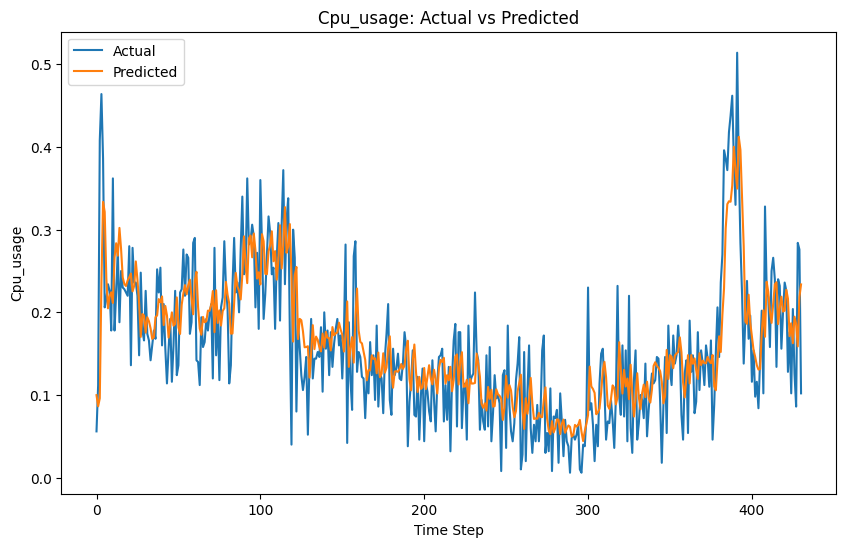

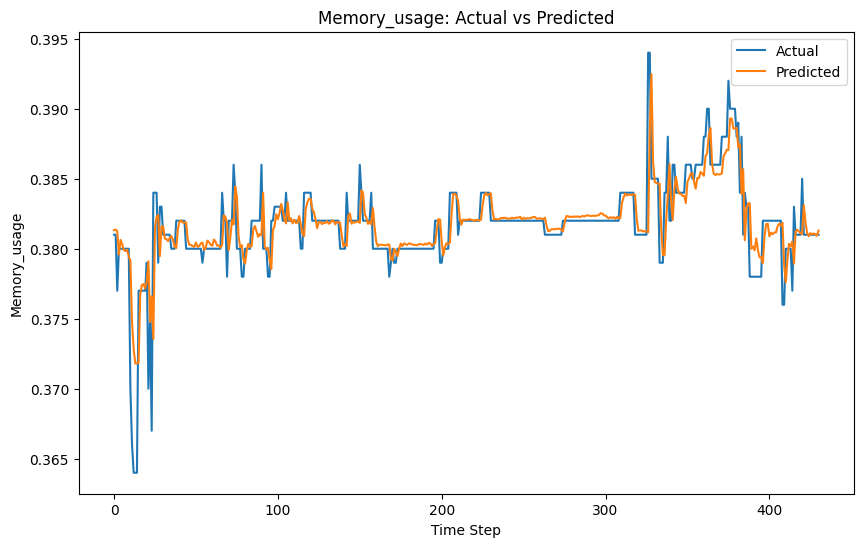

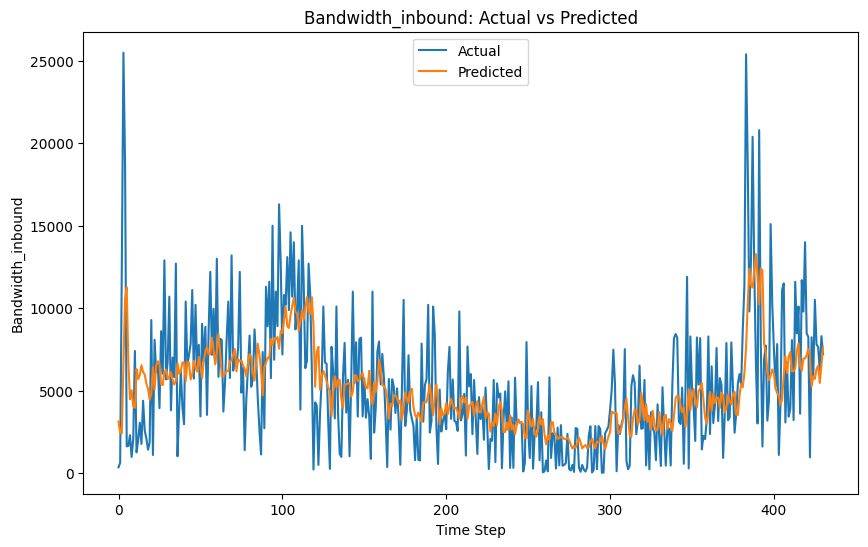

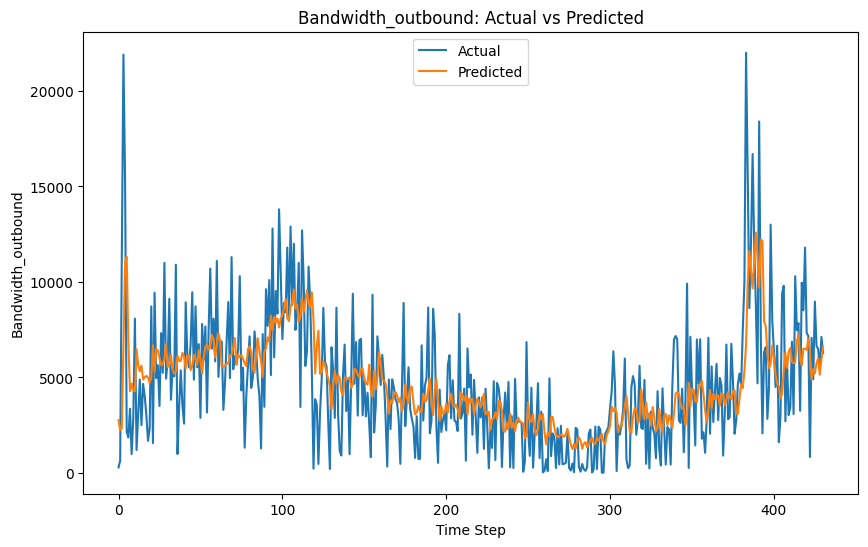

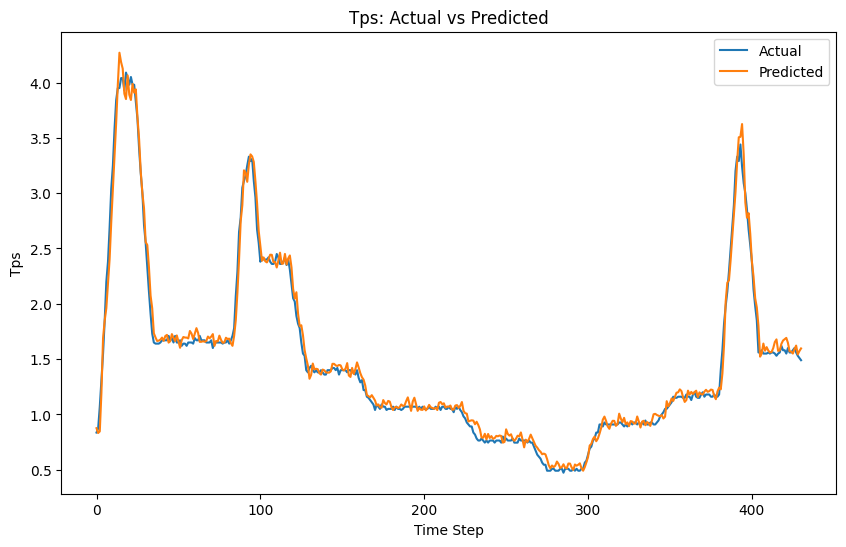

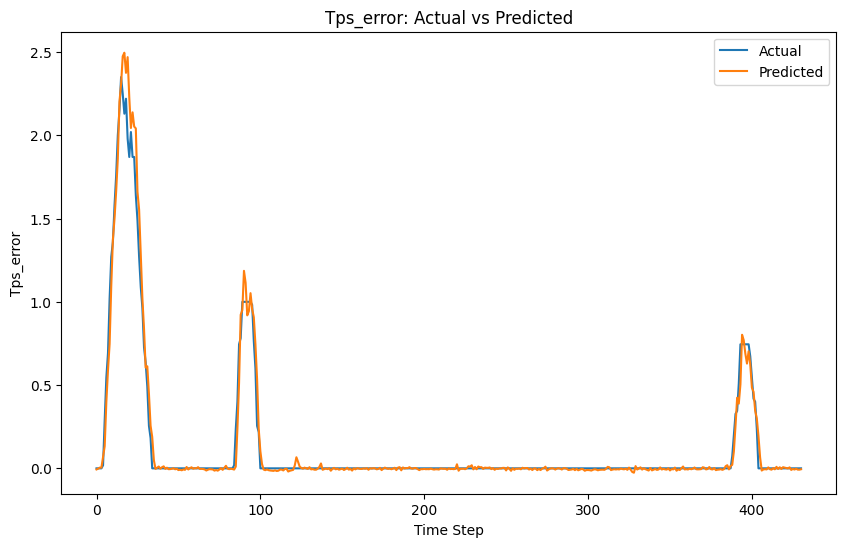

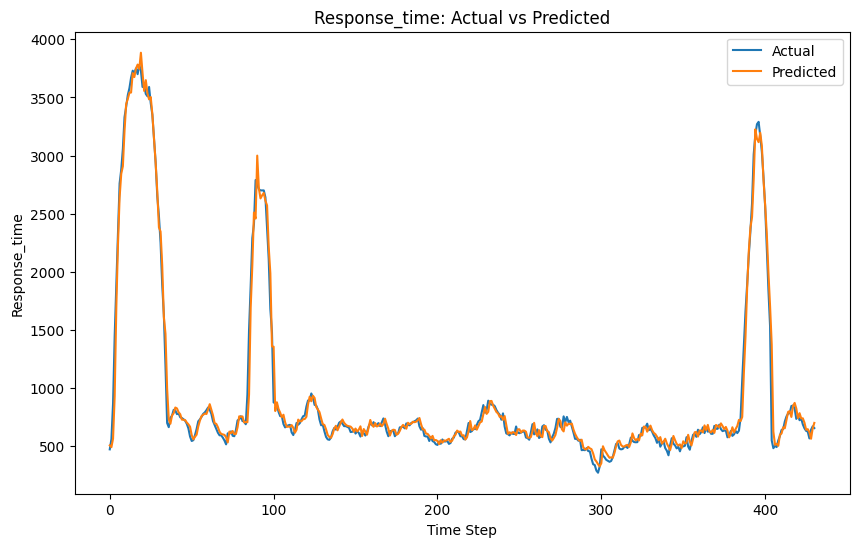

In [21]:
# Plot actual vs predicted
for i, target_col in enumerate(target_columns):
    plt.figure(figsize=(10, 6))
    plt.plot(scalers[target_col].inverse_transform(test[n_past:, i].reshape(-1,1)), label='Actual')
    plt.plot(scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1)), label='Predicted')
    plt.title(f'{target_col.capitalize()}: Actual vs Predicted')
    plt.ylabel(f'{target_col.capitalize()}')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()

### Export the model

In [28]:
pickle.dump(models, open('../../models/multivariate/lstm/models.p', 'wb'))
pickle.dump(scalers, open('../../models/multivariate/lstm/_scalers.p', 'wb'))
pickle.dump(predictions, open('../../models/multivariate/lstm/_predictions_result.p', 'wb'))
pickle.dump(statuses, open('../../models/multivariate/lstm/_statuses_test.p', 'wb'))